# MCMC function

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def target_dist(x):
    mu = 70
    sig = 2
    return np.exp(-0.5 * ((x-mu)/sig)**2)

def candidate_dist(x, sig=0.5):
    return np.random.normal(x, sig)
    
def mcmc_sampler(num_samples, initial_state, proposal_sigma):
    samples = [initial_state]

    for _ in range(num_samples):
        current_state = samples[-1]
        proposed_state = candidate_dist(current_state, proposal_sigma)
        acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)

        if np.random.rand() < acceptance_ratio:
            samples.append(proposed_state)
        else:
            samples.append(current_state)

    return np.array(samples)

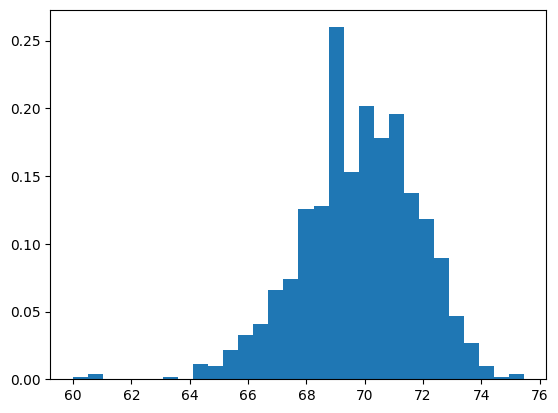

In [3]:
samples = mcmc_sampler(1000, 60, 2)
plt.hist(samples, bins=30, density=True)
plt.show()

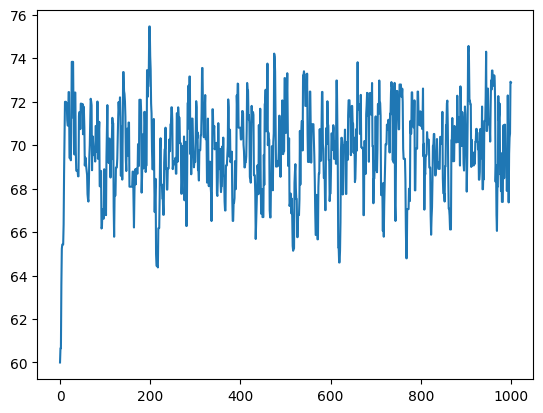

In [4]:
plt.plot(samples)
plt.show()

# GP model

<Axes: >

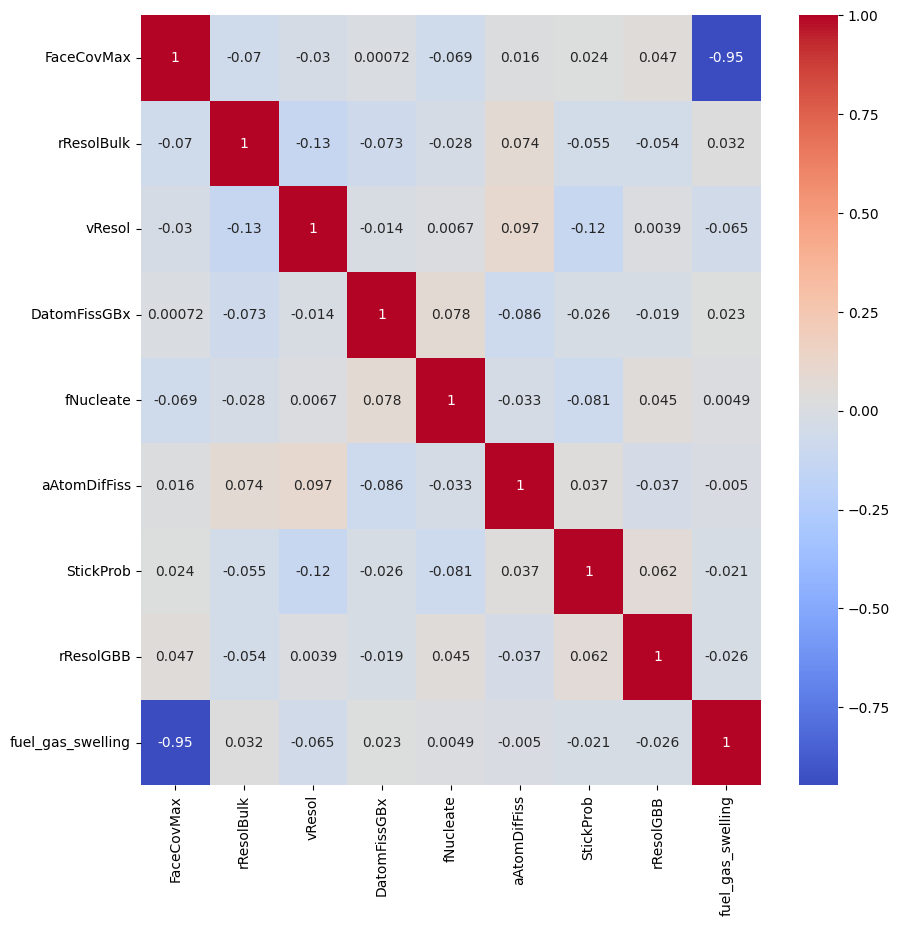

In [5]:
jar = pd.read_csv('data.csv')
jar.drop('fuel_swelling', axis=1, inplace=True)
jar = jar[jar['fuel_gas_swelling'] <= 100]

plt.figure(figsize=(10,10))
sns.heatmap(jar.corr(), annot=True, cmap='coolwarm')

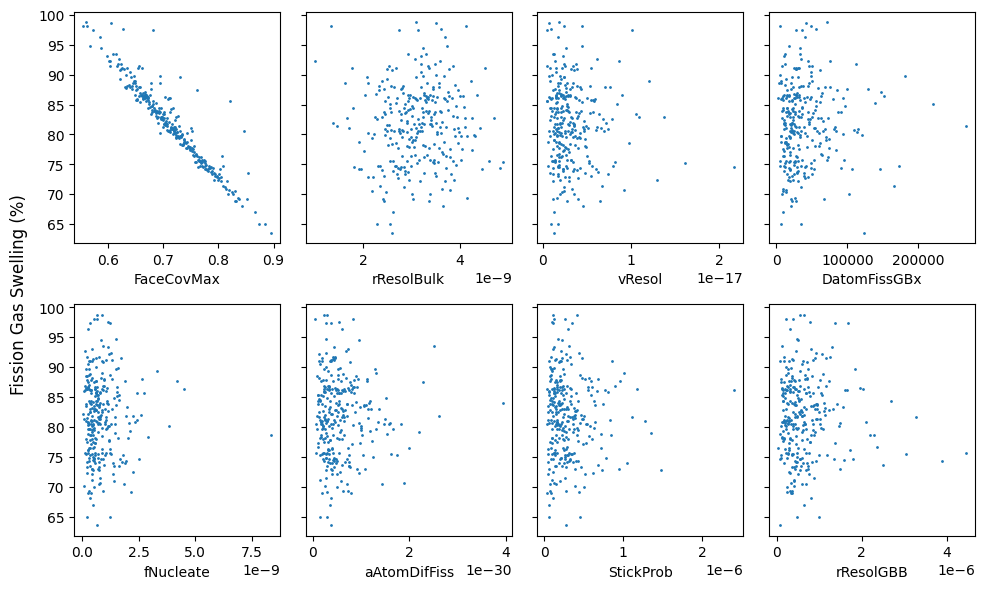

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(jar.iloc[:,i], jar.iloc[:,8], s=1)
    ax.set_xlabel(jar.columns[i])
    #ax.set_ylabel(jar.columns[-1])

fig.supylabel('Fission Gas Swelling (%)')
plt.tight_layout()
plt.show()

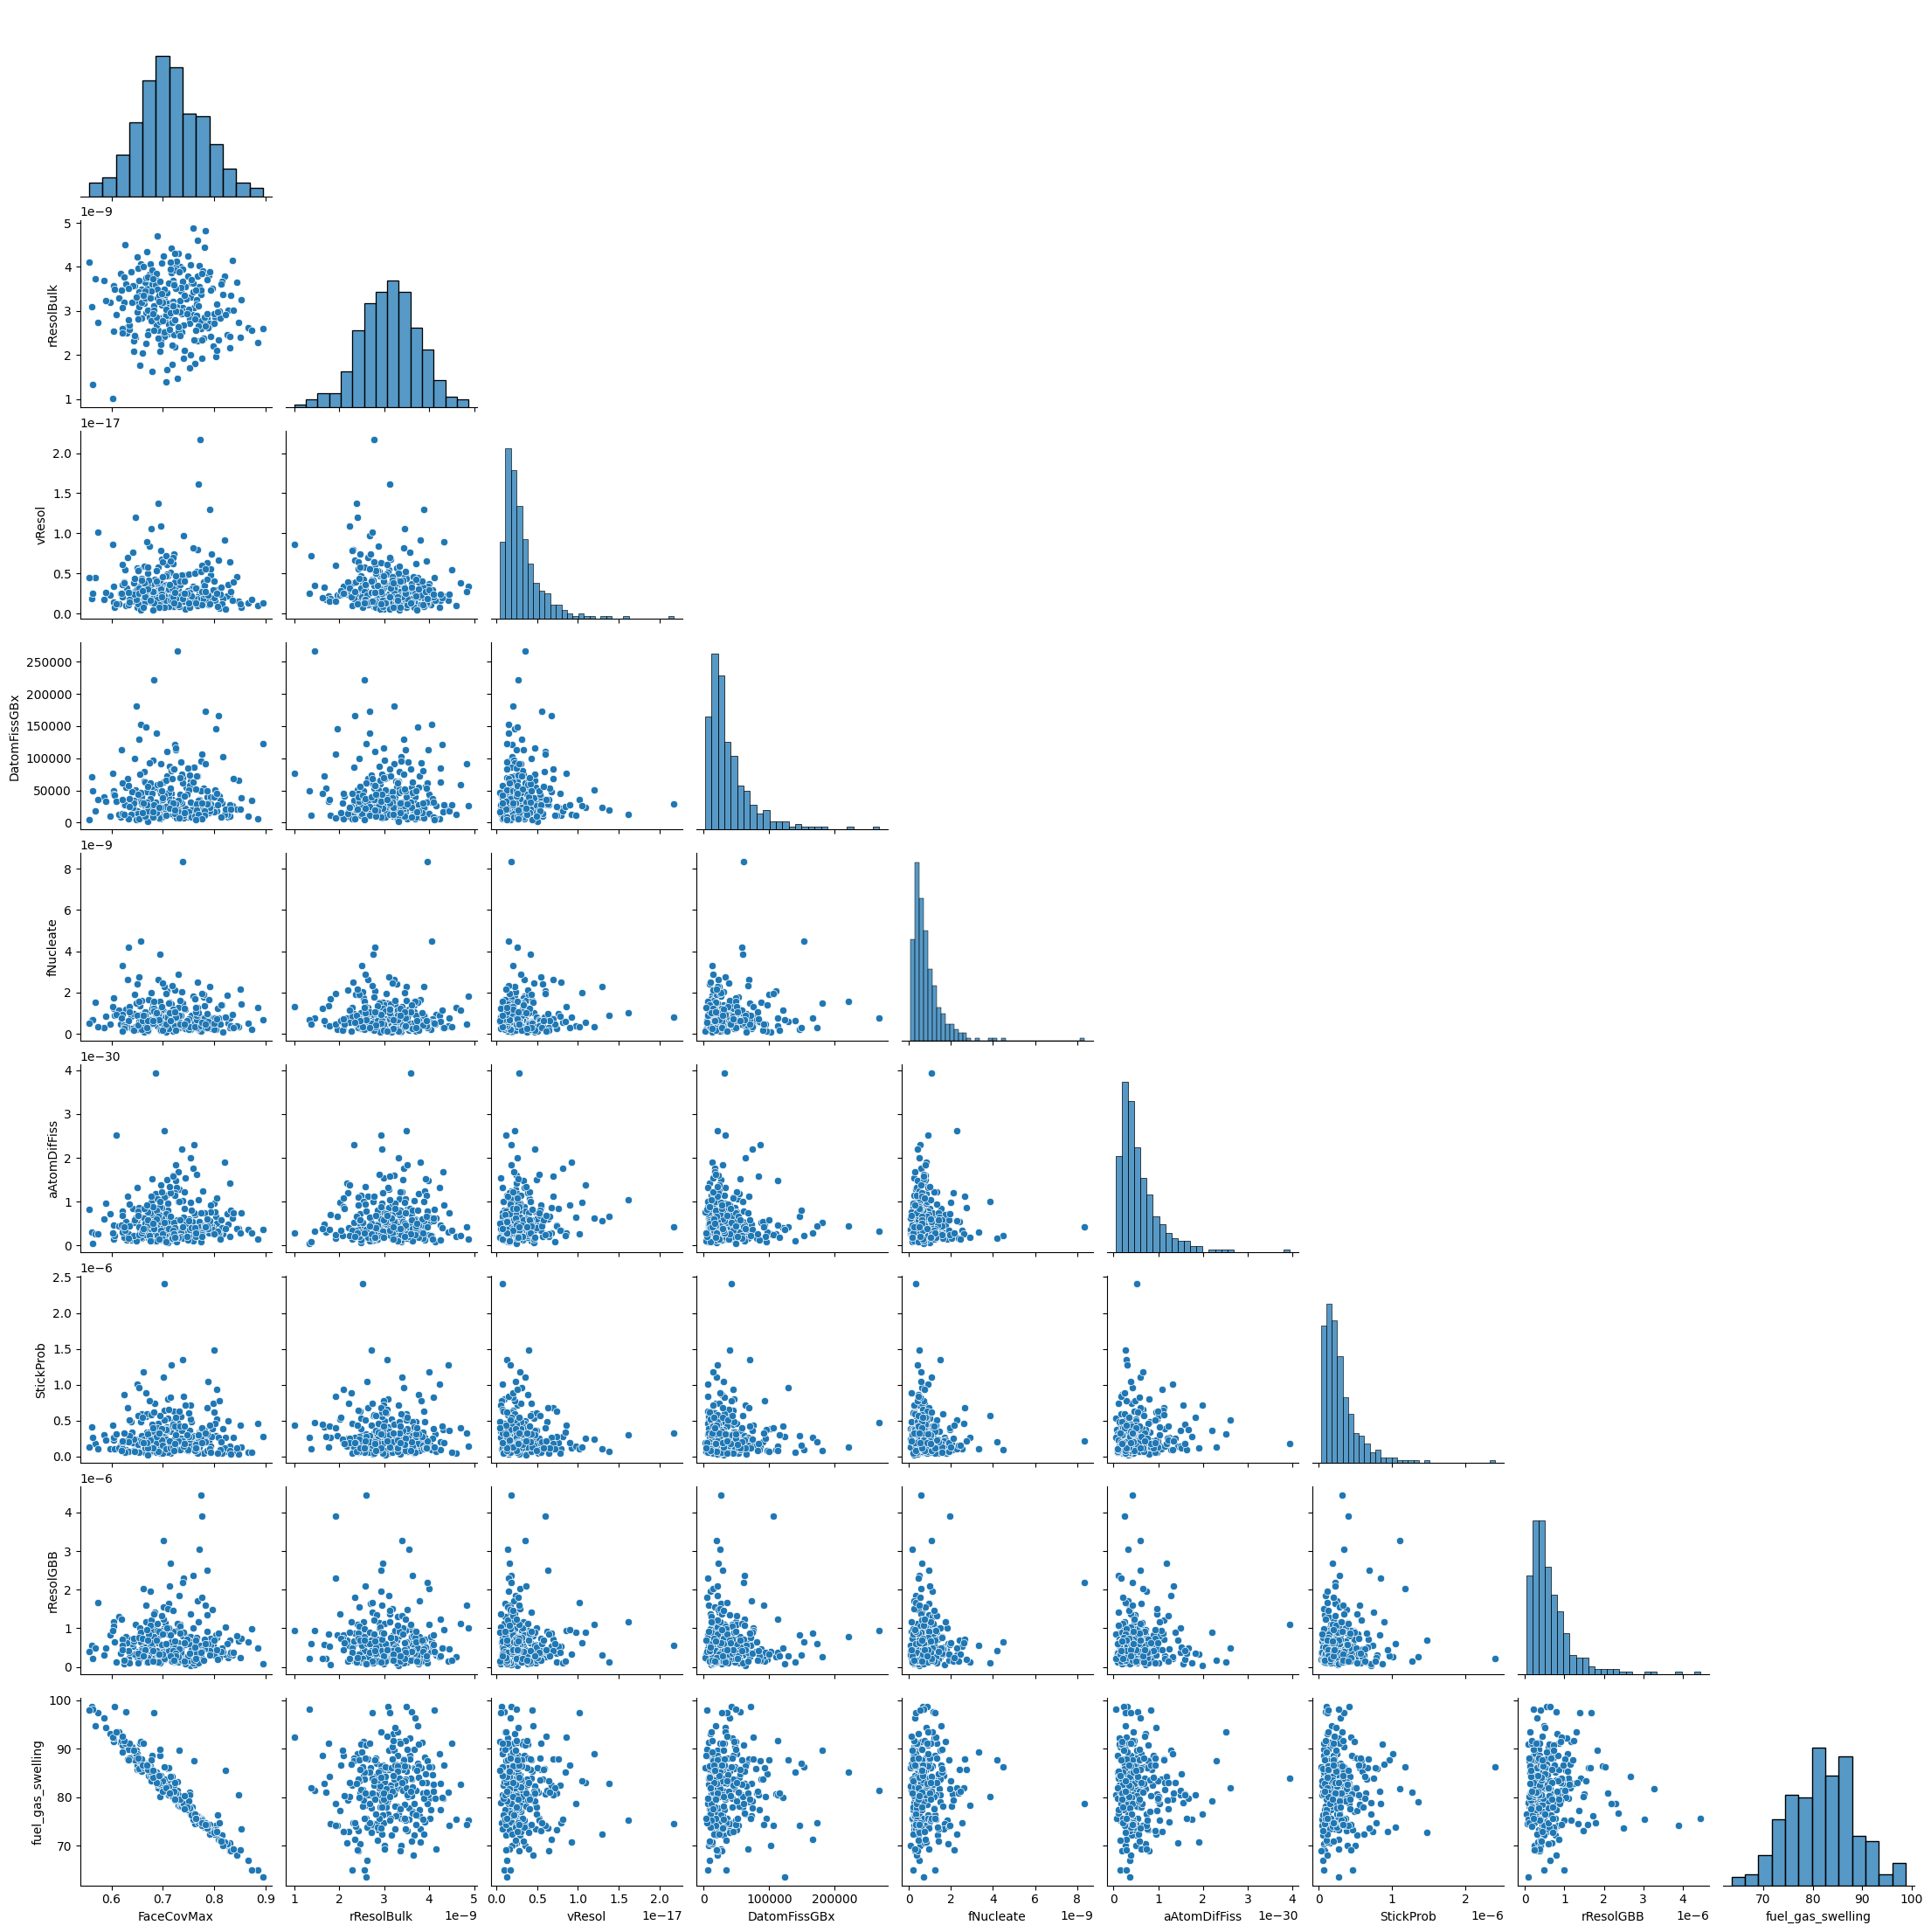

In [7]:
sns.pairplot(jar, corner=True)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

In [9]:
feat_ind = list(range(8))
features = jar.iloc[:, feat_ind]
xscaler = StandardScaler()
X = xscaler.fit_transform(features)
y = jar['fuel_gas_swelling']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
#kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel = Matern()
gpreg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gpreg.fit(X_train, y_train)

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5),
                         n_restarts_optimizer=9)

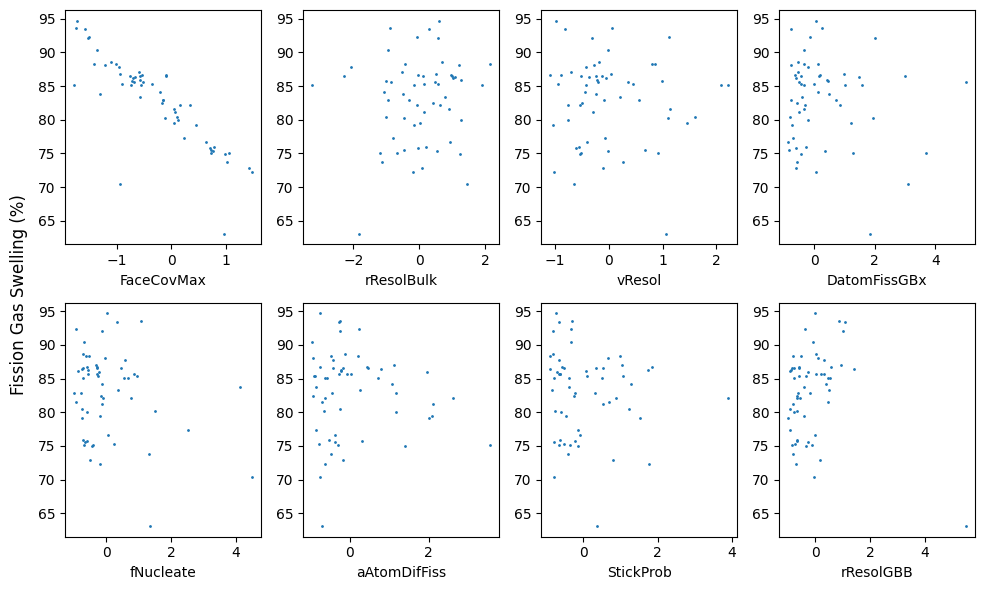

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

y_pred = gpreg.predict(X_test)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(X_test[:,i], y_pred, s=1)
    ax.set_xlabel(jar.columns[i])

fig.supylabel('Fission Gas Swelling (%)')
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.6313816903825782

# Let's hope

In [15]:
def target_dist(x):
    mu = 70
    sig = 3
    return np.exp(-0.5 * ((x-mu)/sig)**2)

def candidate_dist(x, sig=0.5):
    return np.random.normal(x, sig)
    
def mod_mcmc_sampler(num_param, num_samples, initial_state, proposal_sigma, model):
    samples = [initial_state]

    for ii in range(num_samples):
        current_state = samples[-1]
        
        for jj in range(num_param):
            current_p = current_state[jj]
            proposed_p = 10
            while (abs(proposed_p) > 4):
                proposed_p = candidate_dist(current_p, proposal_sigma)

            proposed_state = copy.deepcopy(current_state)
            proposed_state[jj] = proposed_p
            theta1 = model.predict([[*current_state]])[0]
            theta2 = model.predict([[*proposed_state]])[0]

            #acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)
            acceptance_ratio = target_dist(theta2) / target_dist(theta1)

            if np.random.rand() < acceptance_ratio:
                current_state = proposed_state

        samples.append(current_state)

    return np.array(samples)

In [ ]:
hey = mod_mcmc_sampler(8, 10000, np.zeros(8), 0.3, gpreg)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.hist(hey[:,i], bins=30, ec='k')
    ax.set_xlabel(jar.columns[i])
    ax.set_ylabel('')

fig.supylabel('Density')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.plot(hey[:,i], lw=0.1)
    ax.set_xlabel(jar.columns[i])

fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

In [ ]:
isit = []
for i in range(8):
    print(np.mean(hey[20000:50000,i]))
    isit.append(np.mean(hey[20000:50000,i]))

In [ ]:
isit

In [ ]:
gpreg.predict([[*isit]])

In [ ]:
jude = mod_mcmc_sampler(8, 50000, np.ones(8)*2, 0.3, gpreg)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.hist(jude[:,i], bins=30, ec='k')
    ax.set_xlabel(jar.columns[i])
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.plot(jude[:,i], lw=0.1)
    ax.set_xlabel(jar.columns[i])

fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

In [ ]:
isit = []
for i in range(8):
    print(np.mean(jude[20000:50000,i]))
    isit.append(np.mean(jude[20000:50000,i]))

In [ ]:
gpreg.predict([[*isit]])

In [ ]:
np.ones(8) * 2

# Reduced

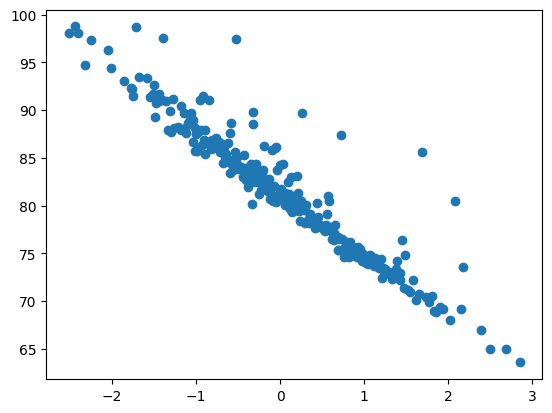

In [16]:
plt.scatter(X[:,0], y)

In [17]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [18]:
#kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
kernel = DotProduct() + WhiteKernel()
gpred = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gpred.fit(X_train, y_train)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=9)

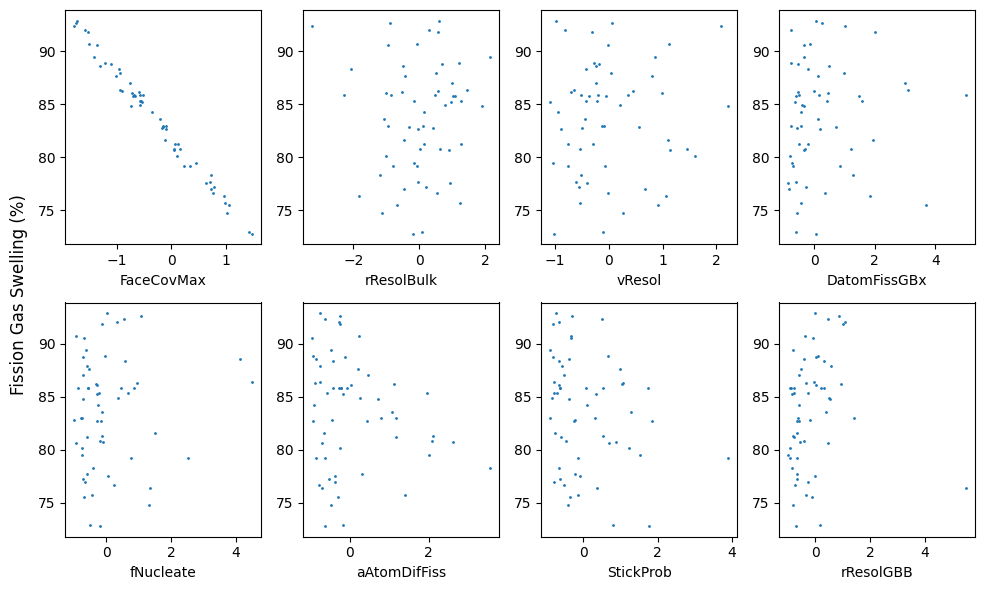

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

y_pred = gpred.predict(X_test)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(X_test[:,i], y_pred, s=1)
    ax.set_xlabel(jar.columns[i])

fig.supylabel('Fission Gas Swelling (%)')
plt.tight_layout()
plt.show()

In [20]:
r2_score(y_test, y_pred)

0.8999654810439889

In [21]:
yeh = mod_mcmc_sampler(8, 50000, np.zeros(8), 0.3, gpred)

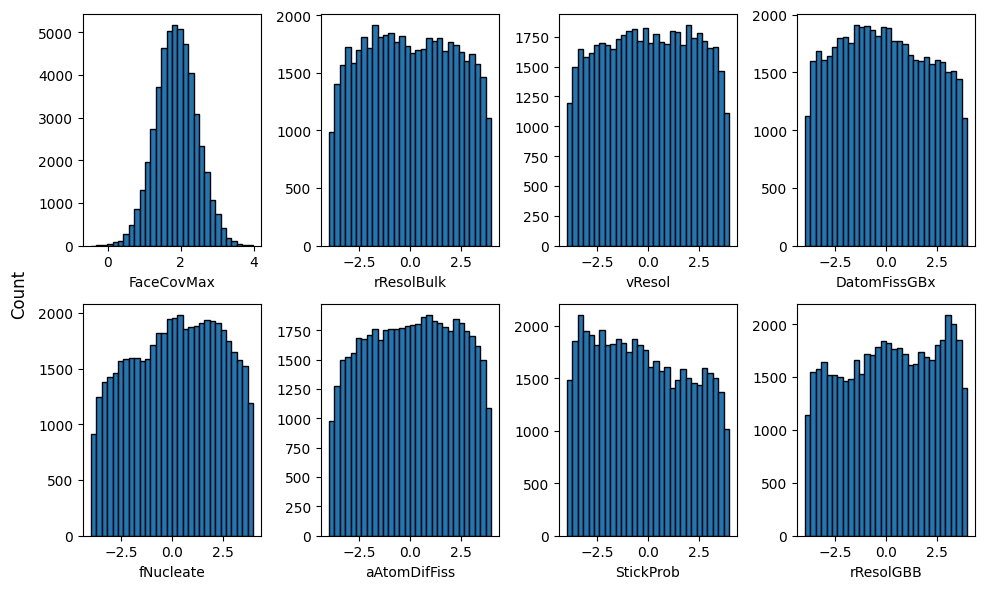

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.hist(yeh[:,i], bins=30, ec='k')
    ax.set_xlabel(jar.columns[i])
    ax.set_ylabel('')

fig.supylabel('Count')
plt.tight_layout()
plt.show()

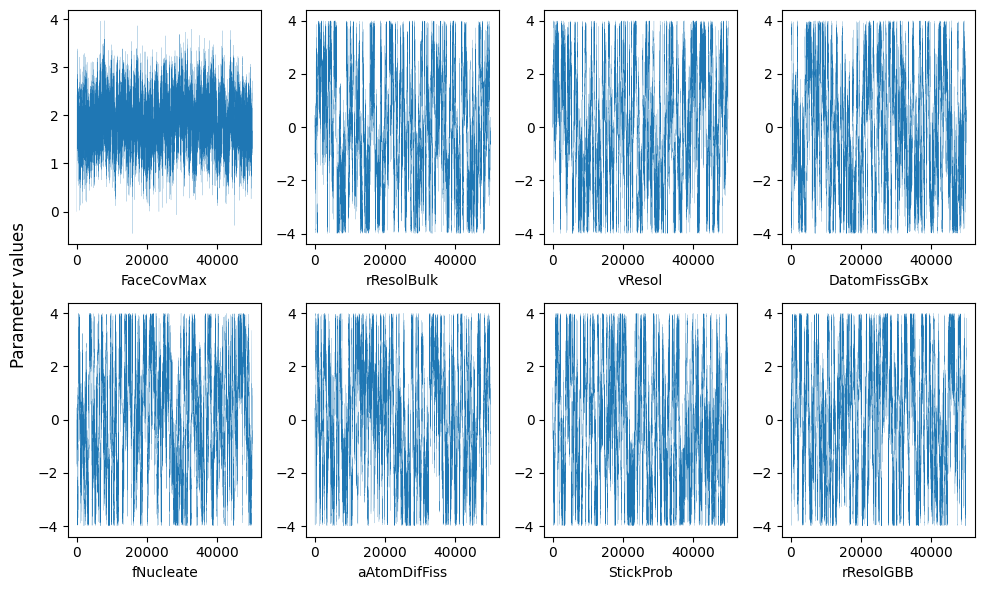

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.plot(yeh[:,i], lw=0.1)
    ax.set_xlabel(jar.columns[i])

fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()

In [24]:
ay = []
for i in range(8):
    print(np.mean(yeh[:,i]))
    ay.append(np.mean(yeh[:,i]))

1.8682506968882329
-0.0026269034778513686
0.016395674276353085
-0.08054806561956629
0.16004171957578195
0.07982516622956176
-0.24599313936495829
0.15716371695369546


In [25]:
gpred.predict([[*ay]])

array([70.04256586])

In [26]:
rng = np.random.RandomState(0)
X_p = rng.randn(290, 8)

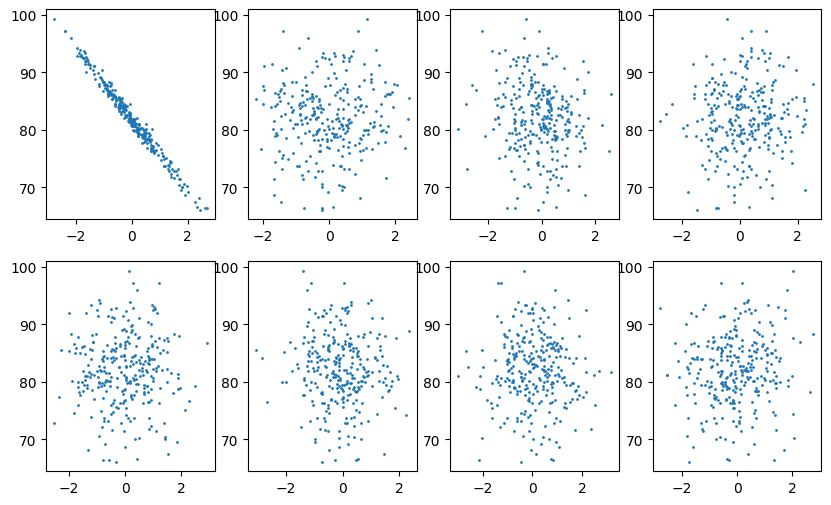

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

y_pred = gpred.predict(X_p)
for i, ax in enumerate(axes.flatten()):
    ax.scatter(X_p[:,i], y_pred, s=1)
    
plt.show()

In [28]:
np.mean(yeh[:,0])

1.8682506968882329

In [29]:
np.std(yeh[:,0])

0.5579470550053075

In [30]:
yeh.shape

(50001, 8)

In [31]:
ohno = xscaler.inverse_transform(yeh)

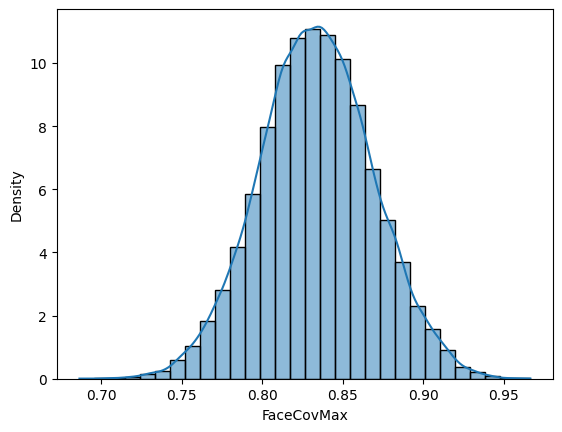

In [32]:
sns.histplot(ohno[:,0], kde=True, bins=30, ec='k', stat='density')

plt.xlabel(jar.columns[0])
plt.show()

In [33]:
np.mean(ohno[:,0])

0.8335867592567355

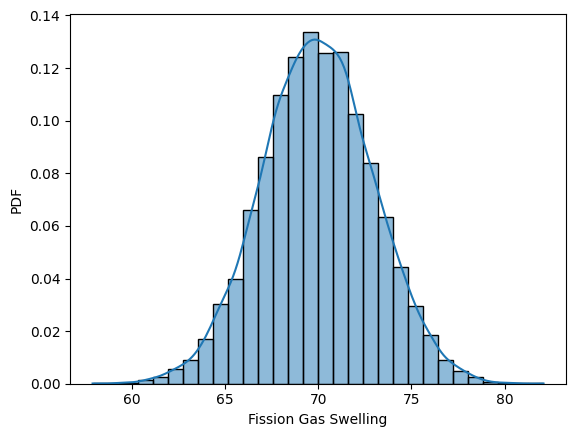

In [34]:
asdf = []
for i in range(10000):
    asdf.append(np.random.normal(70, 3))
    
sns.histplot(asdf, kde=True, bins=30, ec='k', stat='density')

plt.xlabel('Fission Gas Swelling')
plt.ylabel('PDF')
plt.show()

# Push forward

In [35]:
orig = []
res = []
for i in range(10000):
    a = np.random.normal(1.886, 0.555)
    b = []
    for j in range(7):
        b.append(np.random.uniform(-4, 4))
    res.extend(gpred.predict([[a, *b]]))
    c = np.random.normal(70, 3)
    orig.append(c)

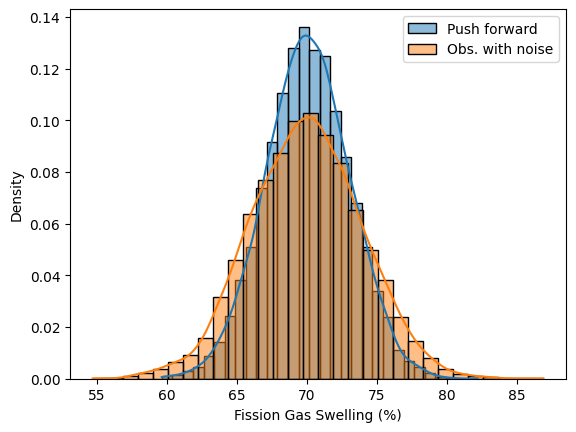

In [36]:
sns.histplot(orig, kde=True, bins=30, ec='k', stat='density', label='Push forward')
sns.histplot(res, kde=True, bins=30, ec='k', stat='density', label='Obs. with noise')

plt.xlabel('Fission Gas Swelling (%)')
plt.legend()
plt.show()